In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

In [0]:
!pip install catboost

 ## Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

 ## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

 ## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Plot Confusion Matrix
    sns.heatmap(cm, vmin = 0, 
                annot = True, 
                linewidths = 0.5, 
                fmt = 'g',
                cmap = "RdBu_r")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    
    # Priht predictions
    print('==============================')
    print('accuracy = {}'.format(accuracy))
    print('precision = {}'.format(precision))
    print('recall = {}'.format(recall))
    print('f1 score = {}'.format(f1))
    print('==============================')
    print(classification_report(y_true, y_pred))

 ## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (12, 6))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

 ## Drop 'Time', 'Amount'

In [10]:
drop_list = ['Time', 'Amount']
X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 384 
fraud cases in test-set:  108


## Classifiers: LightGBM, XGBoost, CatBoost

### 1. LightGBM Classifier

In [0]:
lgbm_params = {'colsample_bytree': 0.5914306621816168, 
               'learning_rate': 0.06072545230769029, 
               'max_depth': -1, 
               'min_child_samples': 353, 
               'min_child_weight': 31.90539884546828, 
               'n_estimators': 100, 
               'num_leaves': 24, 
               'reg_alpha': 9.452281385624794, 
               'reg_lambda': 10.990480792763224, 
               'subsample': 0.8667548610309412, 
               'n_jobs': -1}

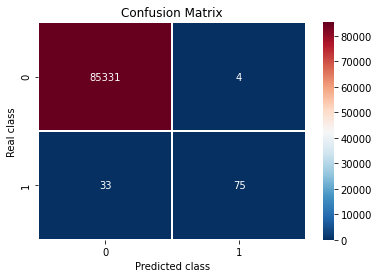

accuracy = 0.9995669627705019
precision = 0.9493670886075949
recall = 0.6944444444444444
f1 score = 0.8021390374331551
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.95      0.69      0.80       108

    accuracy                           1.00     85443
   macro avg       0.97      0.85      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [12]:
lgbm_clf = LGBMClassifier(**lgbm_params)
lgbm_clf.fit(X_train, y_train)
y_score = lgbm_clf.predict_proba(X_test)[:, 1]
y_pred = lgbm_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

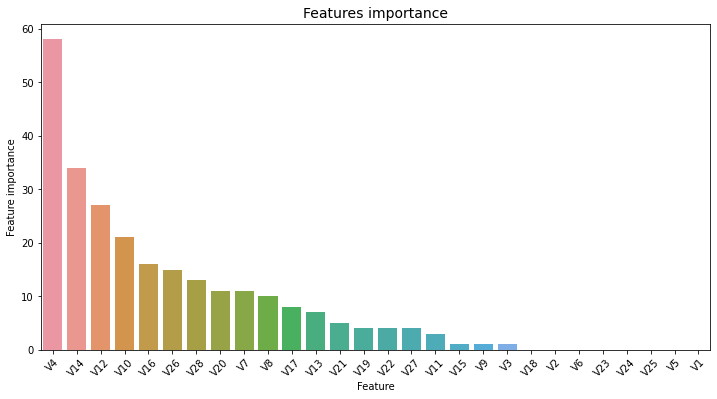

In [13]:
plot_feature_importance(model = lgbm_clf, predictors = predictor_name)

In [0]:
# ROC curve & Precision-Recall curve
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_score)
roc_auc_lgbm = roc_auc_score(y_test, y_score)
precision_lgbm, recall_lgbm, threshold_lgbm = precision_recall_curve(y_test, y_score)
f1_lgbm = 2 * (precision_lgbm * recall_lgbm) / (precision_lgbm + recall_lgbm)
pr_auc_lgbm = average_precision_score(y_test, y_score)

###  2. Extreme Gradient Boosting (XGB)

In [0]:
xgb_params = {'alpha': 9.525539467579513, 
              'colsample_bylevel': 1, 
              'colsample_bytree': 0.6686350218804996, 
              'gamma': 1.0765096979662803, 
              'lambda': 4.924318818446344, 
              'learning_rate': 0.2502520904280233, 
              'max_delta_step': 0, 
              'max_depth': 9, 
              'max_leaf_nodes': 10, 
              'min_child_weight': 0.8485373250937833, 
              'n_estimators': 400, 
              'scale_pos_weight': 1, 
              'subsample': 0.9959671263614935, 
              'n_jobs': -1}

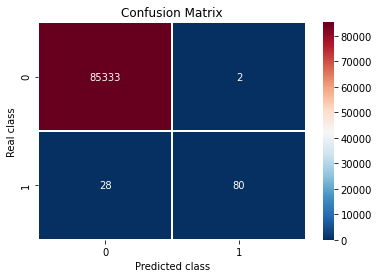

accuracy = 0.9996488887328394
precision = 0.975609756097561
recall = 0.7407407407407407
f1 score = 0.8421052631578947
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.98      0.74      0.84       108

    accuracy                           1.00     85443
   macro avg       0.99      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [20]:
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train, y_train)
y_score = xgb_clf.predict_proba(X_test)[:, 1]
y_pred = xgb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

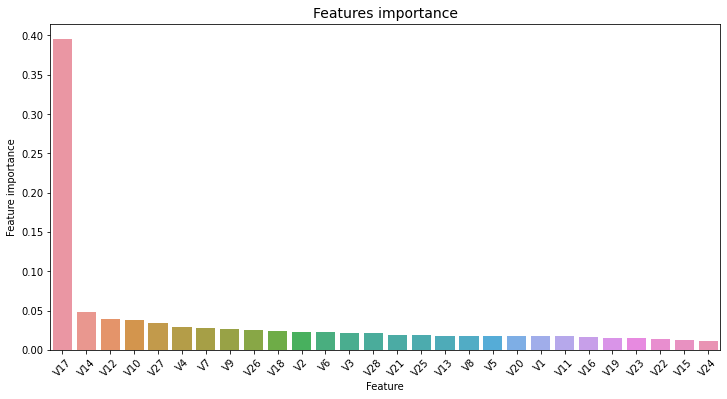

In [21]:
plot_feature_importance(model = xgb_clf, predictors = predictor_name)

In [0]:
# ROC curve & Precision-Recall curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score)
roc_auc_xgb = roc_auc_score(y_test, y_score)
precision_xgb, recall_xgb, threshold_xgb = precision_recall_curve(y_test, y_score)
f1_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb)
pr_auc_xgb = average_precision_score(y_test, y_score)

### 3. CatBoost Classifier

In [0]:
cb_params = {'iterations': 500, 
             'depth': 9.0, 
             'learning_rate': 0.20501067458099742, 
             'l2_leaf_reg': 1.858894753568534, 
             'loss_function': 'Logloss', 
             'eval_metric': 'F1',
             'task_type': 'GPU',
             'verbose': 0}

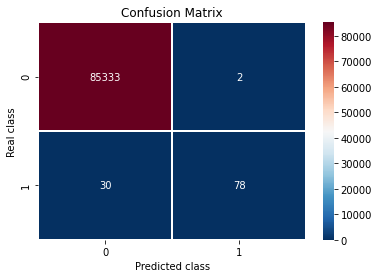

accuracy = 0.9996254813150287
precision = 0.975
recall = 0.7222222222222222
f1 score = 0.8297872340425532
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.97      0.72      0.83       108

    accuracy                           1.00     85443
   macro avg       0.99      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [24]:
cb_clf = CatBoostClassifier(**cb_params)
cb_clf.fit(X_train, y_train)
y_score = cb_clf.predict_proba(X_test)[:, 1]
y_pred = cb_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

In [0]:
# ROC curve & Precision-Recall curve
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_score)
roc_auc_cb = roc_auc_score(y_test, y_score)
precision_cb, recall_cb, threshold_cb = precision_recall_curve(y_test, y_score)
f1_cb = 2 * (precision_cb * recall_cb) / (precision_cb + recall_cb)
pr_auc_cb = average_precision_score(y_test, y_score)

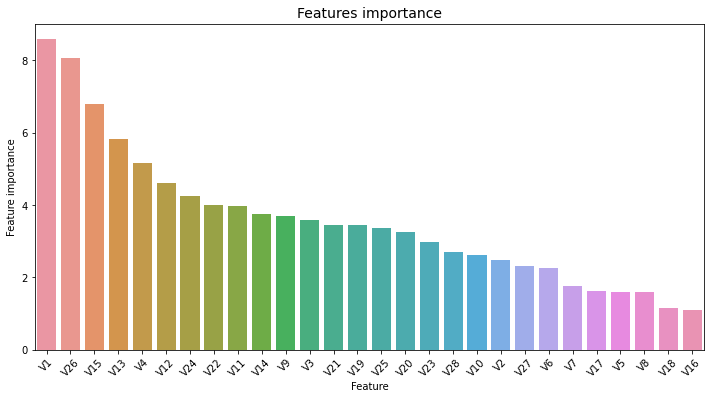

In [26]:
# Plot Feature importance
plot_feature_importance(model = cb_clf, predictors = predictor_name)

### 4. Voting Classifier
Combining classifiers: lgbm_clf, xgb_clf, cb_clf. 

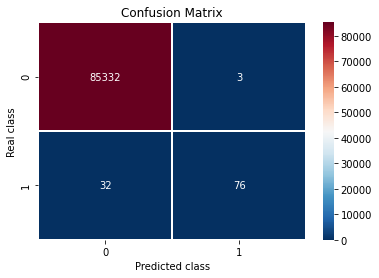

accuracy = 0.9995903701883126
precision = 0.9620253164556962
recall = 0.7037037037037037
f1 score = 0.8128342245989305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.96      0.70      0.81       108

    accuracy                           1.00     85443
   macro avg       0.98      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [27]:
lgbm_clf = LGBMClassifier(**lgbm_params)
xgb_clf = XGBClassifier(**xgb_params)
cb_clf = CatBoostClassifier(**cb_params)
voting_clf = VotingClassifier(estimators = [('lgbm', lgbm_clf), 
                                            ('xgb', xgb_clf), 
                                            ('cb', cb_clf)], 
                              voting = 'soft', 
                              weights = [1, 2, 2])
voting_clf.fit(X_train,y_train)
y_score = voting_clf.predict_proba(X_test)[:,1]
y_pred = voting_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

In [0]:
# ROC curve & Precision-Recall curve
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_score)
roc_auc_voting = roc_auc_score(y_test, y_score)
precision_voting, recall_voting, threshold_voting = precision_recall_curve(y_test, y_score)
f1_voting = 2 * (precision_voting * recall_voting) / (precision_voting + recall_voting)
pr_auc_voting = average_precision_score(y_test, y_score)

In [0]:
def roc_curve_for_all_models():
    plt.figure(figsize = (12, 8))
    plt.plot(fpr_lgbm, tpr_lgbm, label = 'LightGBM: AUC = {:.4f}'.format(roc_auc_lgbm), linewidth = 2)
    plt.plot(fpr_xgb, tpr_xgb, label = 'XGBoost: AUC = {:.4f}'.format(roc_auc_xgb), linewidth = 2)
    plt.plot(fpr_cb, tpr_cb, label = 'CatBoost: AUC = {:.4f}'.format(roc_auc_cb), linewidth = 2)    
    plt.plot(fpr_voting, tpr_voting, label = 'VotingClassifier: AUC = {:.4f}'.format(roc_auc_voting), linewidth = 2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 2)
    plt.xlim([-0.05, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.legend(loc = 'lower right')
    plt.savefig('roc.png')
    plt.show()

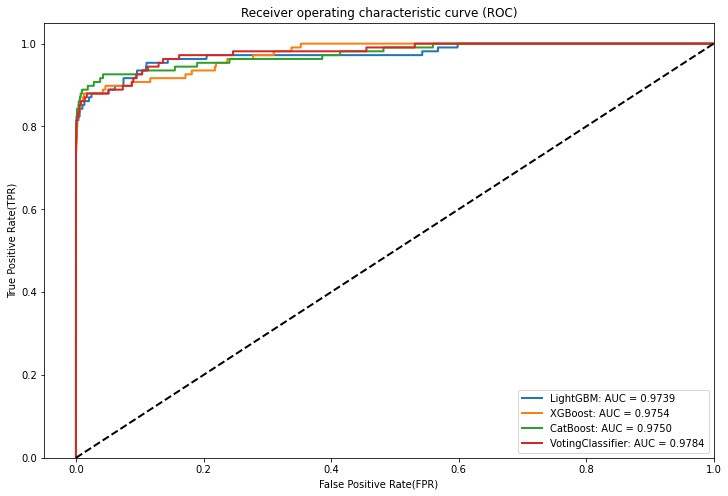

In [30]:
roc_curve_for_all_models()

In [0]:
def precision_recall_for_all_models():
    plt.figure(figsize = (12, 8))
    f_scores = np.linspace(0.2, 0.8, num = 4)
    for f_score in f_scores:
        x = np.linspace(0.001, 1)
        y = f_score * x / (2 * x - f_score)
        plt.plot(x[y >= 0], y[y >= 0], color = 'gray', alpha = 0.2)
        plt.annotate('F1 = {:.2f}'.format(f_score), xy = (0.92, y[45] + 0.02))

    plt.plot(recall_lgbm, precision_lgbm, label = 'LightGBM: AUC = {:.4f}'.format(pr_auc_lgbm), linewidth = 2)
    plt.plot(recall_xgb, precision_xgb, label = 'XGBoost: AUC = {:.4f}'.format(pr_auc_xgb), linewidth = 2)
    plt.plot(recall_cb, precision_cb, label = 'CatBoost: AUC = {:.4f}'.format(pr_auc_cb), linewidth = 2)
    plt.plot(recall_voting, precision_voting, label = 'VotingClassifier: AUC = {:.4f}'.format(pr_auc_voting), linewidth = 2, color = 'r')
    best_index = np.where(f1_voting == f1_voting.max())
    plt.scatter(recall_voting[best_index], precision_voting[best_index], 
                label = 'F1 = %.4f, threshold = %.4f' % (f1_voting[best_index], threshold_voting[best_index]), 
                color = 'r')
    plt.axvline(x = recall_voting[best_index], color = 'r', linestyle = '--', linewidth = 1)
    plt.axhline(y = precision_voting[best_index], color = 'r', linestyle = '--', linewidth = 1)
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend(loc = 'lower left')
    plt.savefig('precision_recall.png')
    plt.show()

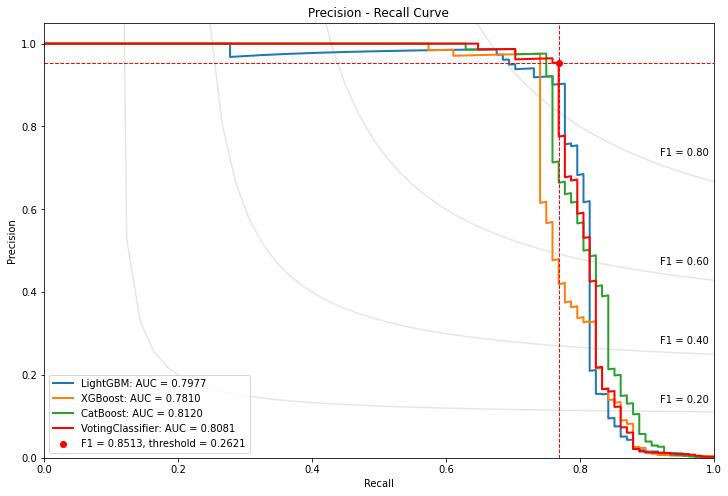

In [46]:
precision_recall_for_all_models() 

In [34]:
f1_lgbm.max()

0.835820895522388

In [33]:
f1_xgb.max()

0.8421052631578947

In [35]:
f1_cb.max()

0.8481675392670156

In [36]:
f1_voting.max()

0.8512820512820513

## Select Threshold By Kfold Cross-Validation

In [0]:
from selectThreshold import selectThresholdByCV
skf = StratifiedKFold(n_splits = 5)
thresholds = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
lgbm_clf = LGBMClassifier(**lgbm_params)
xgb_clf = XGBClassifier(**xgb_params)
cb_clf = CatBoostClassifier(**cb_params)
classifier = VotingClassifier(estimators = [('lgbm', lgbm_clf), 
                                            ('xgb', xgb_clf), 
                                            ('cb', cb_clf)], 
                              voting = 'soft', 
                              weights = [1, 2, 2])

Split0
Split1
Split2
Split3
Split4


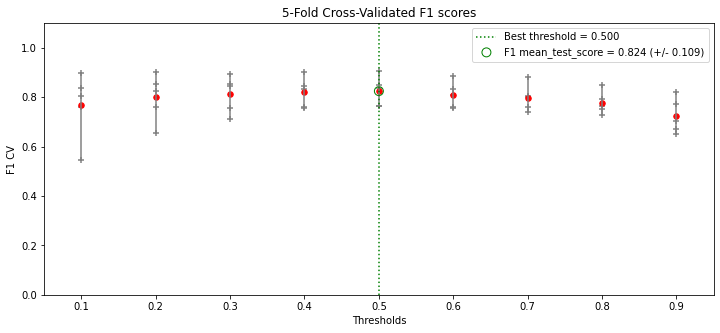

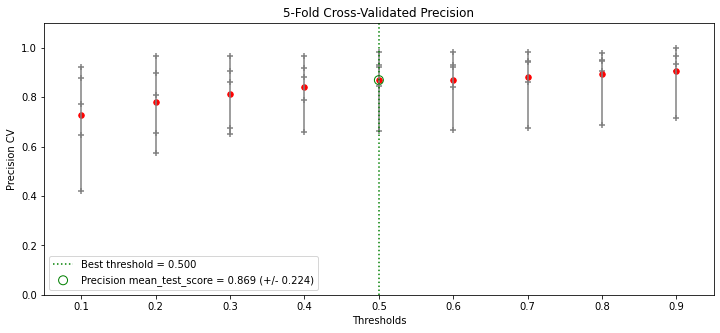

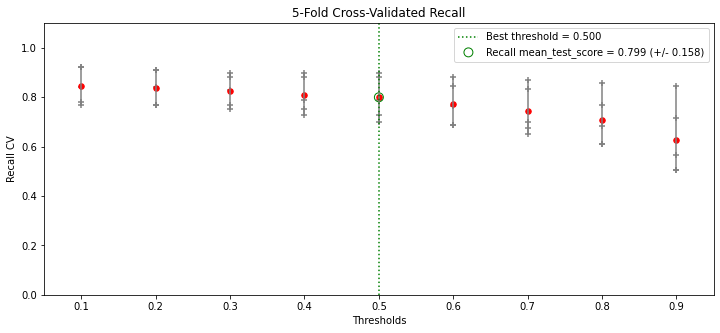

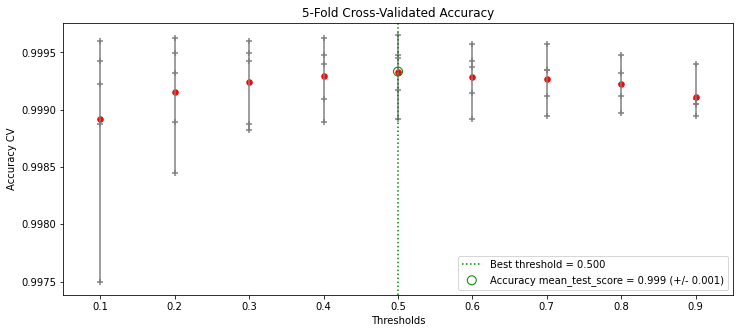

The best threshold = 0.500


In [52]:
best_threshold, best_score, best_std, mean_test_score, std_test_score, cv_results = \
selectThresholdByCV(clf = classifier, 
                    X = X_train, y = y_train, 
                    thresholds = thresholds, 
                    cv = skf, 
                    scoring = 'f1',
                    plot_result = True)
print('The best threshold = %.3f' % (best_threshold))